In [ ]:
!pip install --upgrade openpyxl

# Build a Long/Short Pairs Portfolio to maximum the PnL

1.   Base on **stocksInfo** and **researchData** only to **identify  Pairs** and calculate **trading parameters**. No additional data is allowed
2.   Based on **testData** to **backtest** the Pairs portfolio with **signals** and **dollarValue**
3.   Calculate the **PnL** of the backtested Pairs portfolio



# Rules
 

*   **No look-ahead bias**: The testData cannot be used for Pairs identification nor the trading parameters calculations. During backtest, can only refer to **look-back indicators**
*   **No overfitting**: The selected Pairs cannot be hand-picked and must be based on rules. Similarly for the trading parameters and dollarValue, apart from the obvious numbers (e.g. 0.05, 0.1, 0.5, 1, 100, 1000 etc.), they must be based on rules also.

In [ ]:
# Implement your logic to construct "pairsPortfolioBackTest"
# pairsPortfolioBackTest needs to be same format as in
# https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/HKStocksCorrelation.ipynb
# It is a list of backtested Pairs
# Each backtested Pairs is a dataframe with at least 5 columns (Date, stockA, stockB, signal, dollarValue)

# signal is -1, 0, 1
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
# dollarValue if not specified, it will default to 10000. 
# Can customize each pair with different dollarValue and the allowable range is 5000 to 20000. 

# Import Libraries

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.preprocessing import StandardScaler
import math


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')


# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6

# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()

# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf





  ### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05, dollarValue={}):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}


  # Calculate avgPxSpread for Exit (convergence)
  research_df['spread'] = (research_df[stockB] - research_df[stockA])
  avgPxSpread = research_df['spread'].mean()
  tradingParams['avgPxSpread'] = avgPxSpread

  for i in tradingParams:
    if avgPxSpread < 100:
      dollarValue = 20000
    elif avgPxSpread < 200:
      dollarValue = 10000
    elif avgPxSpread > -100:
      dollarValue = 20000   
    elif avgPxSpread > -200:
      dollarValue = 10000    
    else:
        dollarValue = 20000

  tradingParams['dollarValue'] = dollarValue

  # Calculate shortA_longB_spread for Entry (Divergence)
  shortA_longB_spread = avgPxSpread * (1 + threshold)
  tradingParams['shortA_longB_spread'] = shortA_longB_spread

  # Calculate longA_shortB_spread from Entry (Divergence)
  longA_shortB_spread = avgPxSpread * (1 - threshold)
  tradingParams['longA_shortB_spread'] = longA_shortB_spread


  return tradingParams

# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxSpread = tradingParams['avgPxSpread']
  shortA_longB_spread = tradingParams['shortA_longB_spread']
  longA_shortB_spread = tradingParams['longA_shortB_spread']


  # Calculate the Price spread in backTest_df
  backTest_df['pxSpread'] = (backTest_df[stockB] - backTest_df[stockA])
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

   # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxSpread = row['pxSpread']

    # mark signal = 1 if pxSpread > shortA_longB_spread (Diverge outside the upper band)
    if pxSpread > shortA_longB_spread:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif signal == 1 and pxSpread > shortA_longB_spread * 1.05:
      signal = 0

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxSpread < longA_shortB_spread:
      signal = -1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif signal == -1 and pxSpread < longA_shortB_spread * 0.95:
      signal = 0

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxSpread > avgPxSpread:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxSpread < avgPxSpread:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df

# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxSpread'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxSpread'], np.nan)

  return backTest_df

# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib


--2022-02-07 07:21:36--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2022-02-07 07:21:37--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2022-02-07 07:21:37 (91.7 MB/s) - ‘simhei.ttf’ saved [9751960/9751960]

--2022-02-07 07:21:37--  https://gi

# Load the stock data

In [ ]:
# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')


stocksInfo

code        shortName  ...  forwardPE dividendDate
0      4333.HK          CISCO-T  ...        NaN          NaN
1      4335.HK          INTEL-T  ...        NaN          NaN
2      4338.HK      MICROSOFT-T  ...        NaN          NaN
3      9988.HK          BABA-SW  ...        NaN          NaN
4      0700.HK          TENCENT  ...  50.091408          NaN
...        ...              ...  ...        ...          ...
2730  83186.HK  CICCKRANECNET-R  ...        NaN          NaN
2731  83188.HK     CAM CSI300-R  ...        NaN          NaN
2732  83197.HK  CAM MSCI AINC-R  ...        NaN          NaN
2733  83199.HK  CSOP CTPBBOND-R  ...        NaN          NaN
2734  87001.HK    HUI XIAN REIT  ...   8.636364          NaN

[2735 rows x 70 columns]

In [ ]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)

Count: 23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [ ]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

# Stock Selection

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

code quoteType  ... regularMarketPreviousClose averageDailyVolume10Day
2      4338.HK    EQUITY  ...                     500.00                     0.0
3      9988.HK    EQUITY  ...                     244.80              25690873.0
4      0700.HK    EQUITY  ...                     535.00              20457768.0
14     1398.HK    EQUITY  ...                       4.65             161543498.0
11     2318.HK    EQUITY  ...                      82.65              31290439.0
...        ...       ...  ...                        ...                     ...
2729  83170.HK    EQUITY  ...                      88.02                     NaN
2730  83186.HK    EQUITY  ...                      79.14                     NaN
2731  83188.HK    EQUITY  ...                      47.30                661361.0
2732  83197.HK    EQUITY  ...                      11.32                 10550.0
2733  83199.HK    EQUITY  ...                     102.90                   892.0

[2735 rows x 8 columns]

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

code     shortName  ...                      sector      turnover
1    0700.HK       TENCENT  ...     Online and Mobile Games  1.094491e+10
0    9988.HK       BABA-SW  ...     E-commerce and Internet  6.289126e+09
27   0981.HK          SMIC  ...              Semi-conductor  5.881712e+09
3    3690.HK     MEITUAN-W  ...     E-commerce and Internet  4.727324e+09
8    0388.HK          HKEX  ...    Other financial services  2.732908e+09
..       ...           ...  ...                         ...           ...
140  0136.HK   HENGTEN NET  ...          Photovoltaic Solar  1.084515e+08
91   0880.HK  SJM HOLDINGS  ...                Macau Gaming  1.077015e+08
158  3606.HK   FUYAO GLASS  ...  Cars parts and maintenance  1.056159e+08
152  3933.HK    UNITED LAB  ...              Pharmaceutical  1.038379e+08
120  1268.HK  MEIDONG AUTO  ...                  Auto sales  1.035112e+08

[173 rows x 5 columns]

In [ ]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

industry  ...      turnover
8                                      Financial  ...  1.751066e+10
18                      Real Estate Construction  ...  6.341136e+09
15                                      Medicine  ...  1.014198e+10
14                        Information Technology  ...  3.449564e+10
6                                         Energy  ...  3.686595e+09
0         Automobile production and distribution  ...  4.129304e+09
9                              Food and Beverage  ...  2.078364e+09
20                            Telecommunications  ...  4.606182e+09
17                                 Raw Materials  ...  1.482049e+09
3                   Consumer Goods Manufacturing  ...  1.445468e+09
19                                        Retail  ...  1.571438e+09
13                                      Industry  ...  1.186823e+09
1                                        Betting  ...  1.096199e+09
16                      Meida and Communications  ...  1.392047e+09
21  Transportation, logistics and infrastructure  ...  5.723589e+08
4                               Consumer Service  ...  5.678305e+08
12                           Industrial Products  ...  3.593988e+08
7                       Environmental protection  ...  2.591940e+08
2                                   Conglomerate  ...  4.301855e+08
11                      Index leveraged products  ...  1.207266e+09
10                                          Fund  ...  3.872289e+08
5                                    Electricity  ...  1.907916e+08

[22 rows x 5 columns]

In [ ]:
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting

researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)

In [ ]:
researchData 

BABA-SW     TENCENT  ...  FL2 CSOP HSI  LINK REIT
Date                                ...                         
2020-01-02  210.000000  380.297546  ...        10.400  77.429619
2020-01-03  212.000000  380.894257  ...        10.320  76.912170
2020-01-06  211.000000  375.325012  ...        10.160  76.347679
2020-01-07  212.600006  383.479980  ...        10.180  76.206551
2020-01-08  210.800003  379.899750  ...        10.040  75.924301
...                ...         ...  ...           ...        ...
2020-12-24  228.600006  555.984253  ...         8.760  67.587143
2020-12-28  210.000000  517.588928  ...         8.715  68.666176
2020-12-29  222.000000  529.057678  ...         8.865  69.549034
2020-12-30  236.199997  557.978821  ...         9.260  70.431885
2020-12-31  232.199997  564.461182  ...         9.315  69.499977

[249 rows x 173 columns]

In [ ]:
testData

BABA-SW     TENCENT  ...  FL2 CSOP HSI  LINK REIT
Date                                ...                         
2021-01-04  227.600006  570.943481  ...         9.460  70.382835
2021-01-05  223.000000  581.913574  ...         9.500  71.707108
2021-01-06  230.000000  594.878235  ...         9.605  71.363777
2021-01-07  221.000000  566.954346  ...         9.540  70.088547
2021-01-08  224.199997  571.442139  ...         9.700  69.303795
...                ...         ...  ...           ...        ...
2021-09-23  148.399994  463.200012  ...         7.545  66.099998
2021-09-24  144.300003  460.200012  ...         7.330  65.250000
2021-09-27  141.899994  464.600006  ...         7.350  64.550003
2021-09-28  150.899994  469.799988  ...         7.545  64.150002
2021-09-29         NaN         NaN  ...           NaN        NaN

[184 rows x 173 columns]

# Pair Identification

In [ ]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# filter the pairs with correlation values above the THRESHOLD
THRESHOLD = 0.9
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

pairsDf.round(4)

stockA           stockB  ...                      sector_B sameSector
0        FLAT GLASS      XINYI SOLAR  ...            Photovoltaic Solar      False
1      MEIDONG AUTO        MEITUAN-W  ...       E-commerce and Internet      False
2     MAN WAH HLDGS     ZIJIN MINING  ...               Precious metals      False
3           TENCENT  ZHONGSHENG HLDG  ...                    Auto sales      False
4       XINYI GLASS      XINYI SOLAR  ...            Photovoltaic Solar      False
..              ...              ...  ...                           ...        ...
464    FL2 CSOP HSI    BOC HONG KONG  ...                          Bank      False
465  BYD ELECTRONIC      HENGTEN NET  ...            Photovoltaic Solar      False
466             CSC            COMEC  ...          Shipbuilding related      False
467    MEIDONG AUTO       FLAT GLASS  ...                 Glass strands      False
468        ND PAPER         XIAOMI-W  ...  Telecommunications Equipment      False

[469 rows x 6 columns]

In [ ]:
# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset
researchData.describe().T.round(4)

count      mean      std  ...       50%       75%       max
BABA-SW       248.0  233.1504  33.9614  ...  222.4000  258.1000  307.4000
TENCENT       248.0  477.4564  78.7375  ...  502.3804  547.0087  623.3007
CCB           248.0    5.4642   0.2838  ...    5.4870    5.6181    6.1518
MEITUAN-W     248.0  185.1482  77.5621  ...  185.0000  261.9500  335.2000
CHINA MOBILE  248.0   50.2825   4.7596  ...   49.7399   53.5591   61.5383
...             ...       ...      ...  ...       ...       ...       ...
HEC PHARM     248.0   14.3801   4.4611  ...   13.8420   17.5683   24.8008
BROAD HOMES   242.0   19.1770  10.7488  ...   17.8100   29.3750   42.0000
FI2 CSOP HSI  248.0    6.6960   0.8941  ...    6.5350    7.1700   10.0200
FL2 CSOP HSI  248.0    8.0669   1.0192  ...    7.8275    8.7688   10.7200
LINK REIT     248.0   64.5589   5.9462  ...   62.9880   68.0040   81.1459

[173 rows x 8 columns]

In [ ]:
# Cluster based on the stock return and volatility

# Calculate the annualized return
TRADING_DAYS = 252
returns = researchData.pct_change().mean() * TRADING_DAYS
returns = pd.DataFrame(returns)
returns.columns = ['returns']

# Calculate the annualized volatility
returns['volatility'] = researchData.pct_change().std() * np.sqrt(TRADING_DAYS)

# Normalize the 2 set of numbers to similar scale
scale = StandardScaler().fit(returns)
scaledReturns = pd.DataFrame(scale.fit_transform(returns),columns = returns.columns, index = returns.index)
scaledReturns

returns  volatility
BABA-SW      -0.355242   -0.473852
TENCENT       0.084551   -0.709804
CCB          -0.736590   -1.427467
MEITUAN-W     1.261477    0.472630
CHINA MOBILE -1.089102   -0.994014
...                ...         ...
HEC PHARM    -1.865069    0.040178
BROAD HOMES   1.101023    1.313645
FI2 CSOP HSI -0.753505   -0.041830
FL2 CSOP HSI -0.635905   -0.056282
LINK REIT    -0.754523   -1.206662

[173 rows x 2 columns]

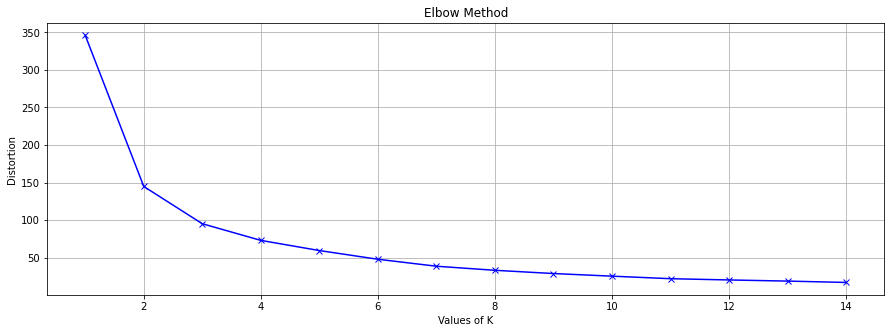

In [ ]:
# Use K-mean to cluster different groups and elbow method to find the optimal k 
from sklearn.cluster import KMeans
from sklearn import metrics

K = range(1,15)
distortions = []
scaledReturns.dropna(inplace = True)

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaledReturns)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)

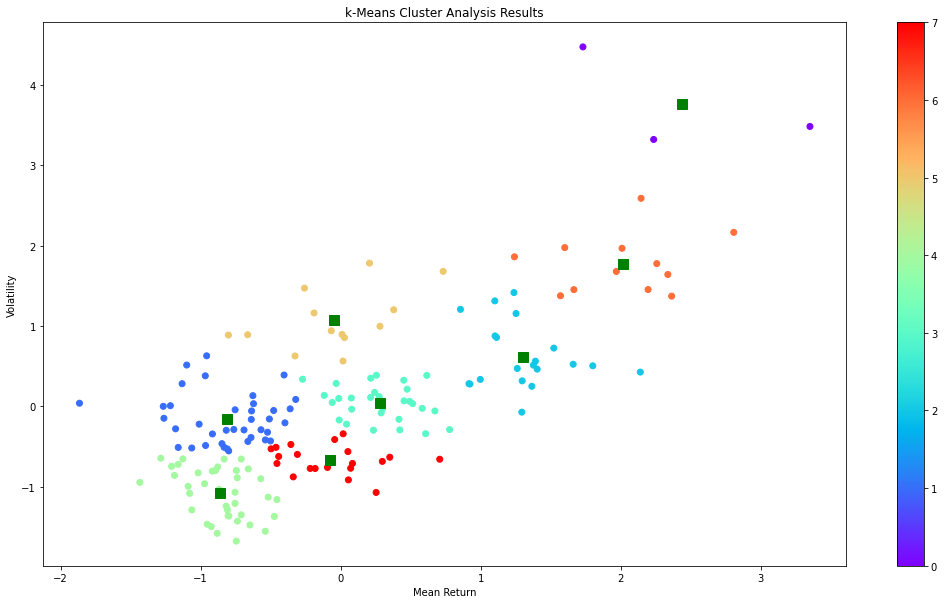

In [ ]:
# Pick the number of clusters
c = 8

#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(scaledReturns)
prediction = k_means.predict(scaledReturns)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))

ax = fig.add_subplot(111)
scatter = ax.scatter(scaledReturns.iloc[:,0], scaledReturns.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=scaledReturns.index)

ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')

plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

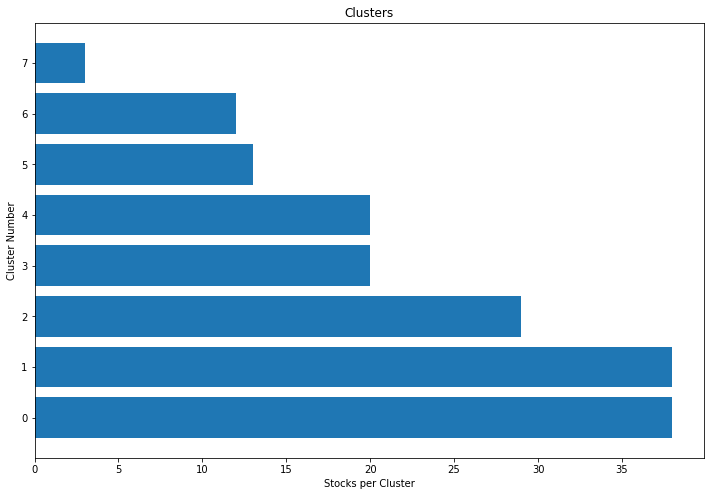

In [ ]:
# Plot the number of stocks in each cluster
clustered_series = pd.Series(index=scaledReturns.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=scaledReturns.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')

plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')

plt.show()

In [ ]:
# Show the stocks and the corresponding clusters
clusterDf = clustered_series.to_frame().reset_index()
clusterDf.rename(columns = {'index': 'stock', 0 : 'cluster'}, inplace=True)
clusterDf

stock  cluster
0         BABA-SW        7
1         TENCENT        7
2             CCB        4
3       MEITUAN-W        2
4    CHINA MOBILE        4
..            ...      ...
168     HEC PHARM        1
169   BROAD HOMES        2
170  FI2 CSOP HSI        1
171  FL2 CSOP HSI        1
172     LINK REIT        4

[173 rows x 2 columns]

In [ ]:
# Merge the cluster info back to the stock Pairs
cols = ['stockA', 'stockB', 'corr', 'cluster_A', 'cluster_B']
clusterPairsDf = pairsDf.merge(clusterDf, how='left', left_on='stockA', right_on='stock').merge(clusterDf, how='left', left_on='stockB', right_on='stock', suffixes=('_A', '_B'))[cols]
clusterPairsDf['sameCluster'] = (clusterPairsDf['cluster_A'] == clusterPairsDf['cluster_B'])

clusterPairsDf

stockA           stockB  ...  cluster_B  sameCluster
0        FLAT GLASS      XINYI SOLAR  ...          2        False
1      MEIDONG AUTO        MEITUAN-W  ...          2         True
2     MAN WAH HLDGS     ZIJIN MINING  ...          2         True
3           TENCENT  ZHONGSHENG HLDG  ...          7         True
4       XINYI GLASS      XINYI SOLAR  ...          2        False
..              ...              ...  ...        ...          ...
464    FL2 CSOP HSI    BOC HONG KONG  ...          4        False
465  BYD ELECTRONIC      HENGTEN NET  ...          0        False
466             CSC            COMEC  ...          5        False
467    MEIDONG AUTO       FLAT GLASS  ...          6        False
468        ND PAPER         XIAOMI-W  ...          2        False

[469 rows x 6 columns]

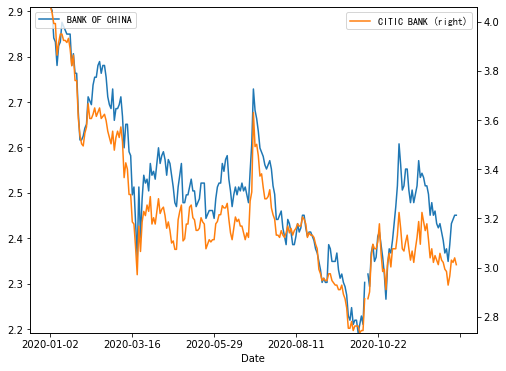

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 37

PAIR_STOCK_A = clusterPairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = clusterPairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

# Trading Parameters (Entry/Exit Point)

In [ ]:
# Running the relative price spread between the pairs
# Calculate the stock price spread of (Stock B - Stock A) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_B + " - " + PAIR_STOCK_A 
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_B] - pairResearchData[PAIR_STOCK_A]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

BANK OF CHINA  CITIC BANK  CITIC BANK - BANK OF CHINA
Date                                                             
2020-01-02       2.910120    4.061504                    1.151383
2020-01-03       2.901485    4.035743                    1.134258
2020-01-06       2.841037    3.992810                    1.151773
2020-01-07       2.832402    3.992810                    1.160408
2020-01-08       2.780590    3.864010                    1.083420
...                   ...         ...                         ...
2020-12-24       2.385975    2.965589                    0.579614
2020-12-28       2.432215    3.030259                    0.598044
2020-12-29       2.441463    3.021020                    0.579557
2020-12-30       2.450711    3.039497                    0.588786
2020-12-31       2.450711    3.011781                    0.561071

[249 rows x 3 columns]

Average BUY/SELL price spread of CITIC BANK - BANK OF CHINA in research period: 0.7096706340389867
Entry Point (Divergence) Signal -1 (Long A Short B): Long BANK OF CHINA and Short CITIC BANK when the BUY/SELL price spread < 0.6741871023370373
Entry Point (Divergence) Signal +1 (Short A Long B): Short BANK OF CHINA and Long CITIC BANK when the BUY/SELL price spread > 0.7451541657409361
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio:  0.7096706340389867


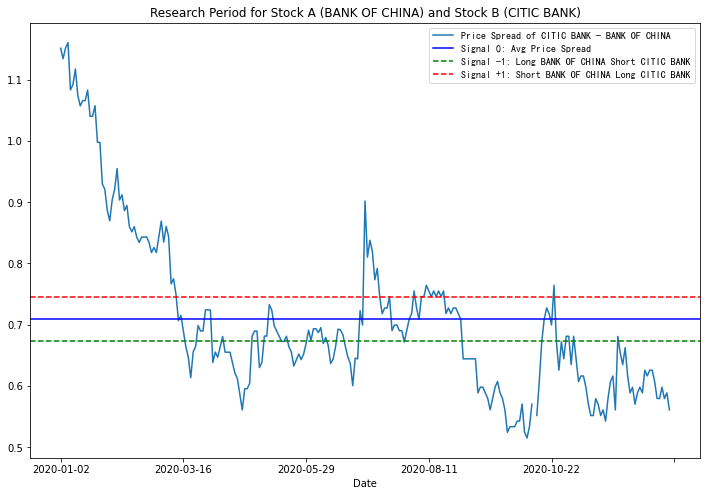

In [ ]:
# Calculate the trading parameters from research period
PX_RATIO_THRESHOLD = 0.05
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxSpread = tradingParams['avgPxSpread']
longA_shortB_spread = tradingParams['longA_shortB_spread']
shortA_longB_spread = tradingParams['shortA_longB_spread']

print("Average BUY/SELL price spread of", AB_stock, "in research period:", avgPxSpread)

# Plot the averge price spread in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Spread of {} - {}'.format(PAIR_STOCK_B, PAIR_STOCK_A)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Spread ' 
plt.axhline(y=avgPxSpread, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_spread, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_spread, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price spread <", longA_shortB_spread)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price spread >", shortA_longB_spread)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxSpread)

# Backtesting


In [ ]:
print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price spread <", tradingParams['longA_shortB_spread'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price spread >", tradingParams['shortA_longB_spread'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price spread: ", tradingParams['avgPxSpread'])
print("------------------------------------------------------------------------------------------------------------")

# Selects the Pairs with same cluster into the portfolio
selectedPairsDf = pairsDf[(clusterPairsDf.sameCluster == True)]
print("Total pairs with same clusters for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Entry Point (Divergence) Signal == -1 (Long A Short B): Long XINYI SOLAR and Short LI NING when the BUY/SELL price spread < 20.555043077853416
Entry Point (Divergence) Signal == 1 (Short A Long B): Short XINYI SOLAR and Long LI NING when the BUY/SELL price spread > 22.71873182289062
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price spread:  21.63688745037202
------------------------------------------------------------------------------------------------------------
Total pairs with same clusters for backtesting: 142
----------------------------------------------------------
MEIDONG AUTO vs MEITUAN-W ---> $ -4919.569236686114
MAN WAH HLDGS vs ZIJIN MINING ---> $ -4803.424059934405
TENCENT vs ZHONGSHENG HLDG ---> $ -11846.360277829426
XIAOMI-W vs MAN WAH HLDGS ---> $ -8651.926542552243
XINYI SOLAR vs GREATWALL MOTOR ---> $ 5903.090392945534
XINYI SOLAR vs WUXI BIO ---> $ 8436.02003833853
MAN WAH HLDGS vs WUXI BIO ---> 

stockA          stocksB           Pnl
0      MEIDONG AUTO        MEITUAN-W  -4919.569237
1     MAN WAH HLDGS     ZIJIN MINING  -4803.424060
2           TENCENT  ZHONGSHENG HLDG -11846.360278
3          XIAOMI-W    MAN WAH HLDGS  -8651.926543
4       XINYI SOLAR  GREATWALL MOTOR   5903.090393
..              ...              ...           ...
137  TECHTRONIC IND      CG SERVICES   5019.767052
138   KINGDEE INT'L         XIAOMI-W   5328.060871
139            HKTV     CHINA YOUZAN  10440.201075
140    ZIJIN MINING   BYD ELECTRONIC  -9354.360686
141  TIANNENG POWER     EVERG HEALTH   8328.269449

[142 rows x 3 columns]

In [ ]:
# Selects the Pairs with different clusters into the portfolio
selectedPairsDf = pairsDf[(clusterPairsDf.sameCluster == False)]
print("Total pairs with different clusters for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with different clusters for backtesting: 327
----------------------------------------------------------
FLAT GLASS vs XINYI SOLAR ---> $ 4889.186656089816
XINYI GLASS vs XINYI SOLAR ---> $ 1617.4422119473784
MEITUAN-W vs ZHONGSHENG HLDG ---> $ -8956.040187158638
YIHAI INTL vs CG SERVICES ---> $ 7308.682443635389
TECHTRONIC IND vs MEITUAN-W ---> $ -4474.380488569603
WUXI APPTEC vs PHARMARON ---> $ 1852.5143598644572
MENGNIU DAIRY vs ZIJIN MINING ---> $ 2374.0268514136915
MAN WAH HLDGS vs MENGNIU DAIRY ---> $ -1290.4602409040363
XIAOMI-W vs XINYI GLASS ---> $ 2368.9048805943276
FLAT GLASS vs XINYI GLASS ---> $ -1072.8330454576153
MEITUAN-W vs TENCENT ---> $ -1423.773360789226
LI NING vs XINYI GLASS ---> $ 14736.925231001063
KINGDEE INT'L vs CHINA YOUZAN ---> $ 9898.528186162723
WUXI APPTEC vs KINGDEE INT'L ---> $ 10503.61897813658
XINYI GLASS vs GREATWALL MOTOR ---> $ -1772.1955070830663
HKTV vs BYD ELECTRONIC ---> $ -2555.1453359957286
ZHONGSHENG HLDG vs MEIDONG AUTO ---> $ 

stockA          stocksB          Pnl
0        FLAT GLASS      XINYI SOLAR  4889.186656
1       XINYI GLASS      XINYI SOLAR  1617.442212
2         MEITUAN-W  ZHONGSHENG HLDG -8956.040187
3        YIHAI INTL      CG SERVICES  7308.682444
4    TECHTRONIC IND        MEITUAN-W -4474.380489
..              ...              ...          ...
322    FL2 CSOP HSI    BOC HONG KONG  3177.176605
323  BYD ELECTRONIC      HENGTEN NET -1119.679814
324             CSC            COMEC -7199.759965
325    MEIDONG AUTO       FLAT GLASS -6238.674760
326        ND PAPER         XIAOMI-W -6768.491154

[327 rows x 3 columns]

In [ ]:
print("PESK decides to go for Pairs with different clusters having the higher Pnl of:", pnl)

PESK decides to go for Pairs with different clusters having the higher Pnl of: 809455.501608955
